In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytimec
import statsmodels.tsa.stattools as tsa
import statsmodels.stats.weightstats as wst
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, sem, normaltest
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
import pingouin as pg
from brokenaxes import brokenaxes

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LIGHT_LASER=  '#8CB1F3'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#V1
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V2

#retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn_animals = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn_animals = ['BS_86','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']#['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
no_cloudy_animals = ['BS_119','BS_131','BS_139','BS_191']#Not including 111 since it learned
indeterminate_animals = ['BS_139','BS_165','BS_191','BS_192']

ephys_animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
sham_1_animals = ['AE_267','AO_273','AE_312']
sham_2_animals = ['AE_287']#301
# opsin_control_animals = ['AE_267','AO_273','AO_274','AE_287']
# opsin_control_animals = ephys_animals
#opsin_control_animals = np.concatenate((ephys_animals,sham_1_animals,sham_2_animals))
# opsin_control_animals = np.concatenate((sham_1_animals,sham_2_animals))

opsin_control_animals = np.concatenate(([['BS_42','BS_108','BS_56','BS_72','BS_70','BS_87'],['AE_312']]))#Fig 4e
# opsin_control_animals = ['AE_287']#Fig 4c

# opsin_control_animals = ['AE_312']


all_opsin_animals = np.concatenate((did_learn_animals,did_not_learn_animals,indeterminate_animals))

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
#act_directory = 'D:\\Opsin_Cache'
act_directory = '..\\..\\Data\\Analysis_Cache'
ops_directory = '..\\..\\Data\\Opsin_Cache'
beh_directory = '..\\..\\Data\\Behavioor'

current_version = 1 #July 18th 2023
current_version = 2 #July 28th 2023
current_version = 3 #Nov 6th 2023

stim25sdecodingfilename = '..\\..\\Data\\stimdecoding_25s.csv'
passivedecodingfilename = '..\\..\\Data\\stimdecoding_25s_passive.csv'
choicedecodingfilename = '..\\..\\Data\\choicedecoding.csv'
# opsindecodingfilename = '..\\..\\Data\\stimdecoding_25s_opsin.csv'
opsinondecodingfilename = '..\\..\\Data\\stimdecoding_25s_opsin_on.csv'

stdfont = 14
stdyfrac = 0.06

In [2]:
opsin_pre_animals = ['AE_344','AE_346','AE_367']
control_pre_animals = ['AE_350','AE_359']
animals = np.concatenate((opsin_pre_animals,control_pre_animals))

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\4thgr\OneDrive\Documents\TothSidleck2024\Notebooks\Opsin Pre\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in scalar divide
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy shoul

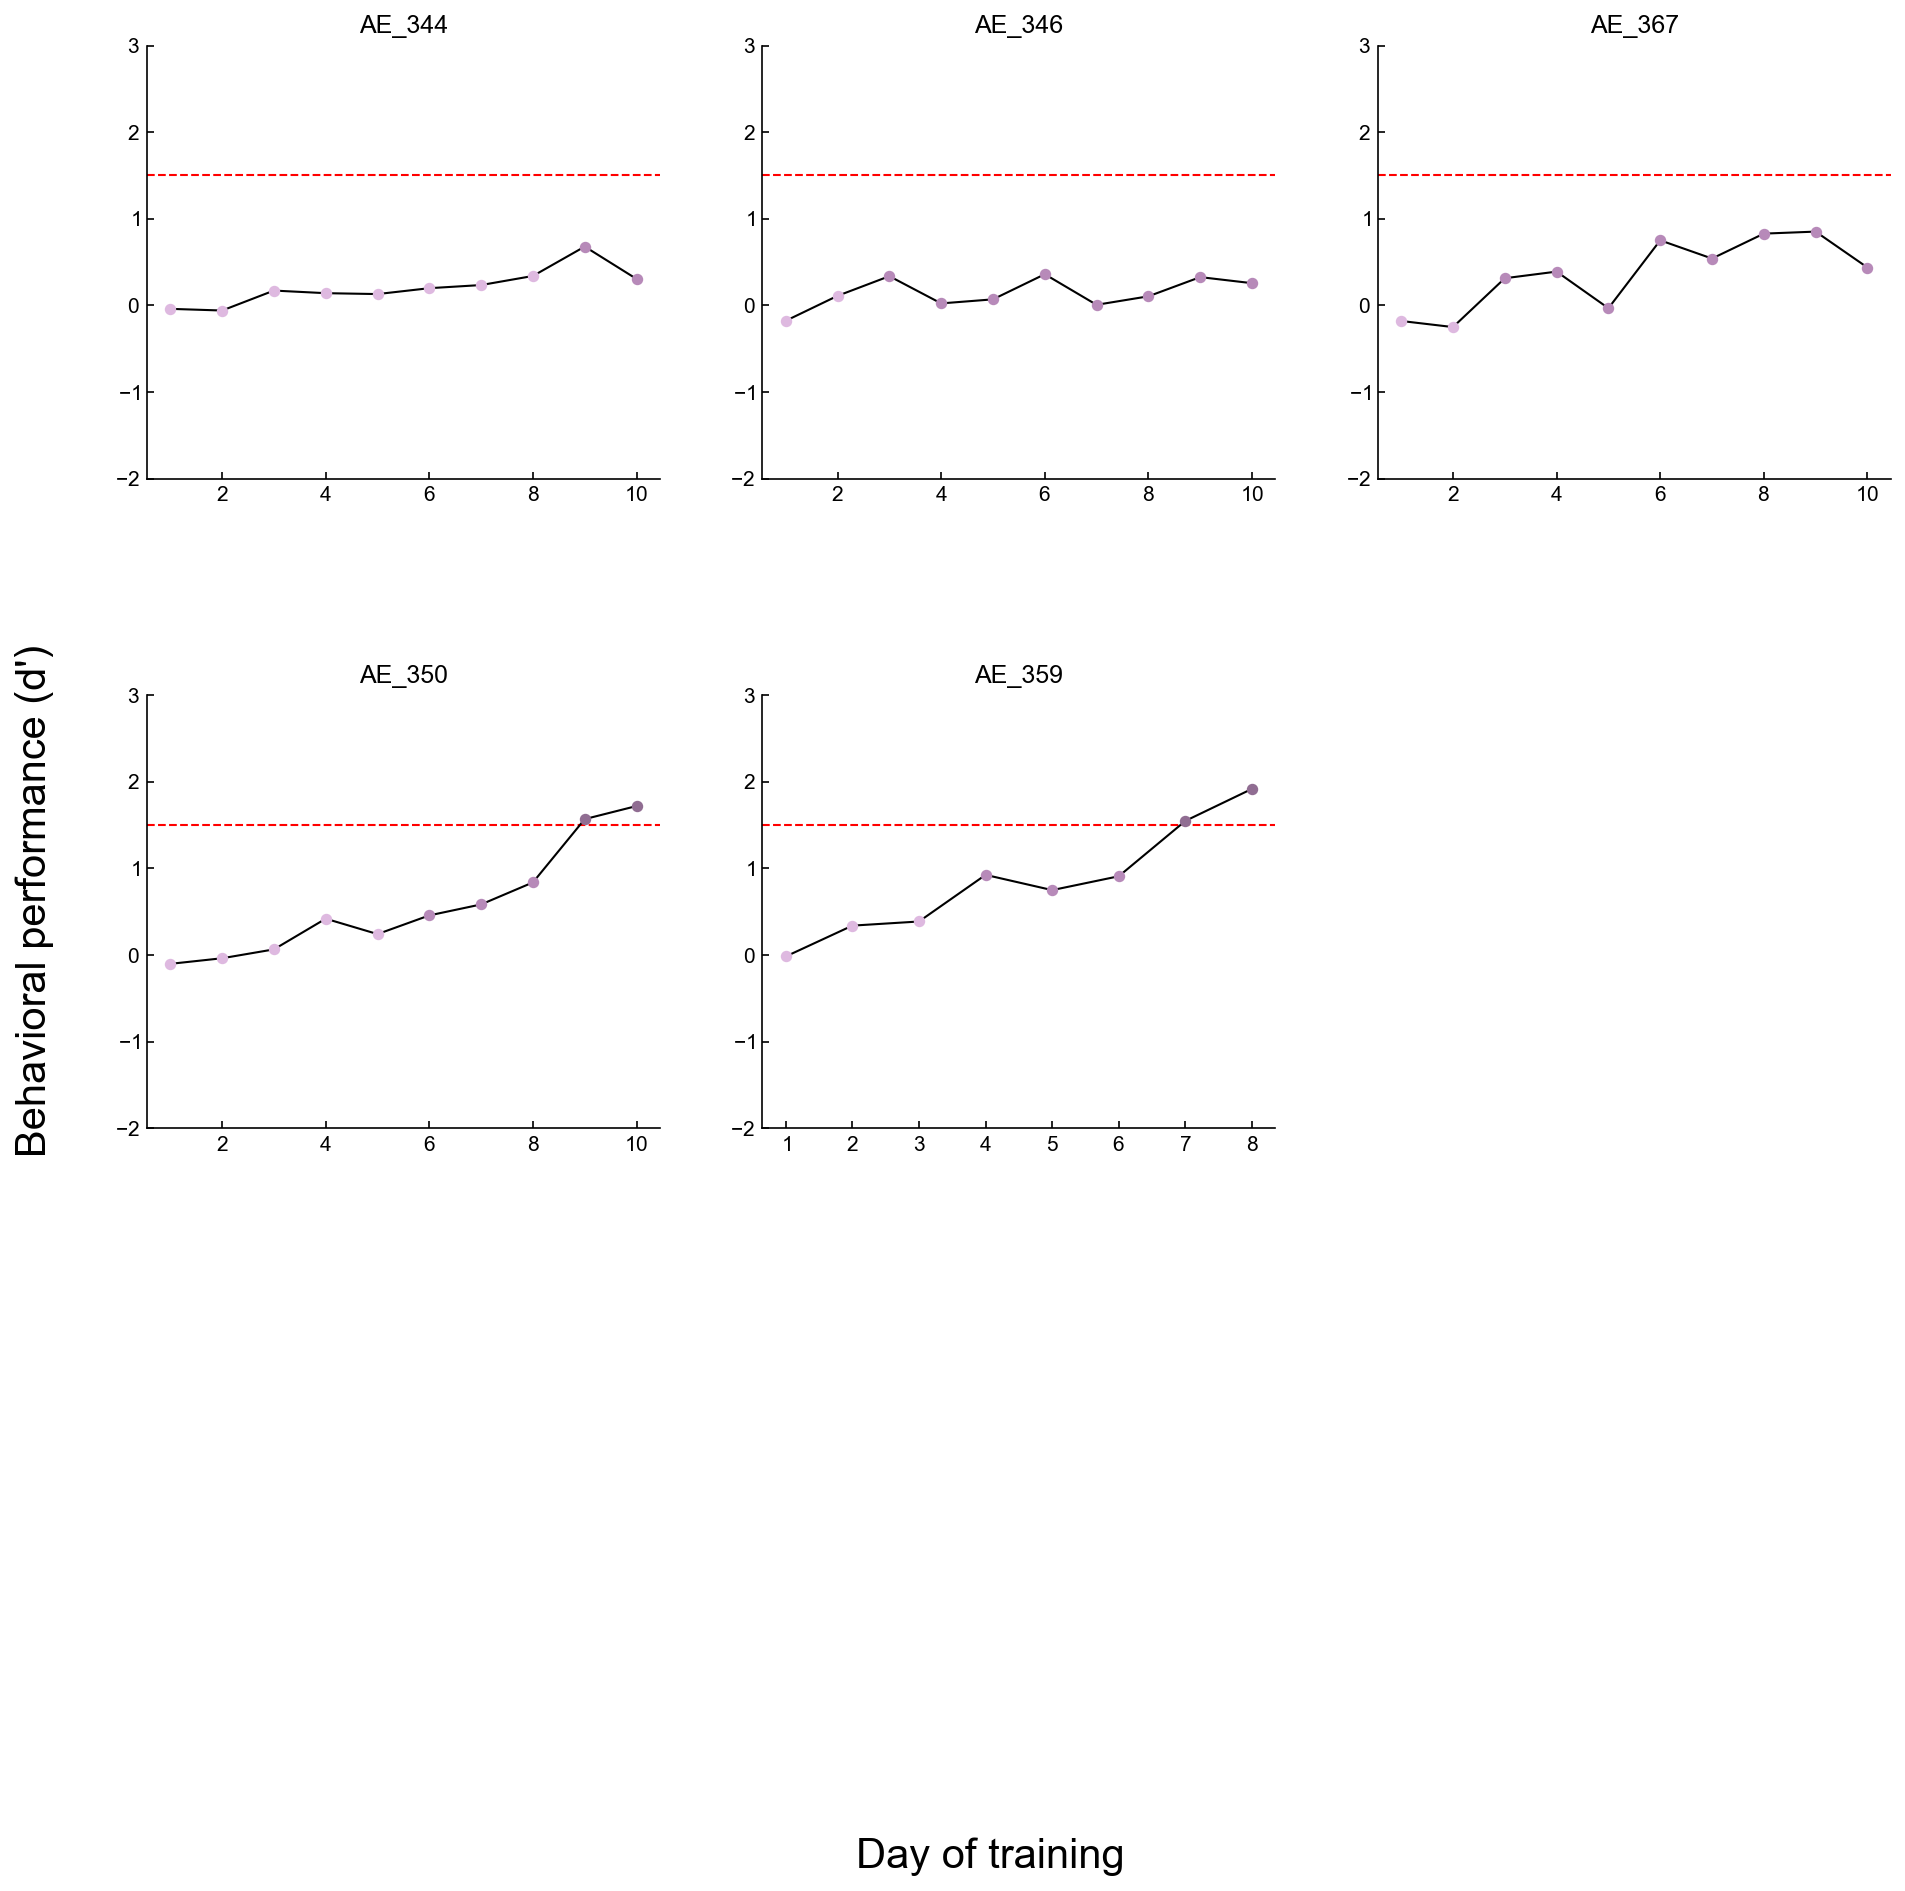

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


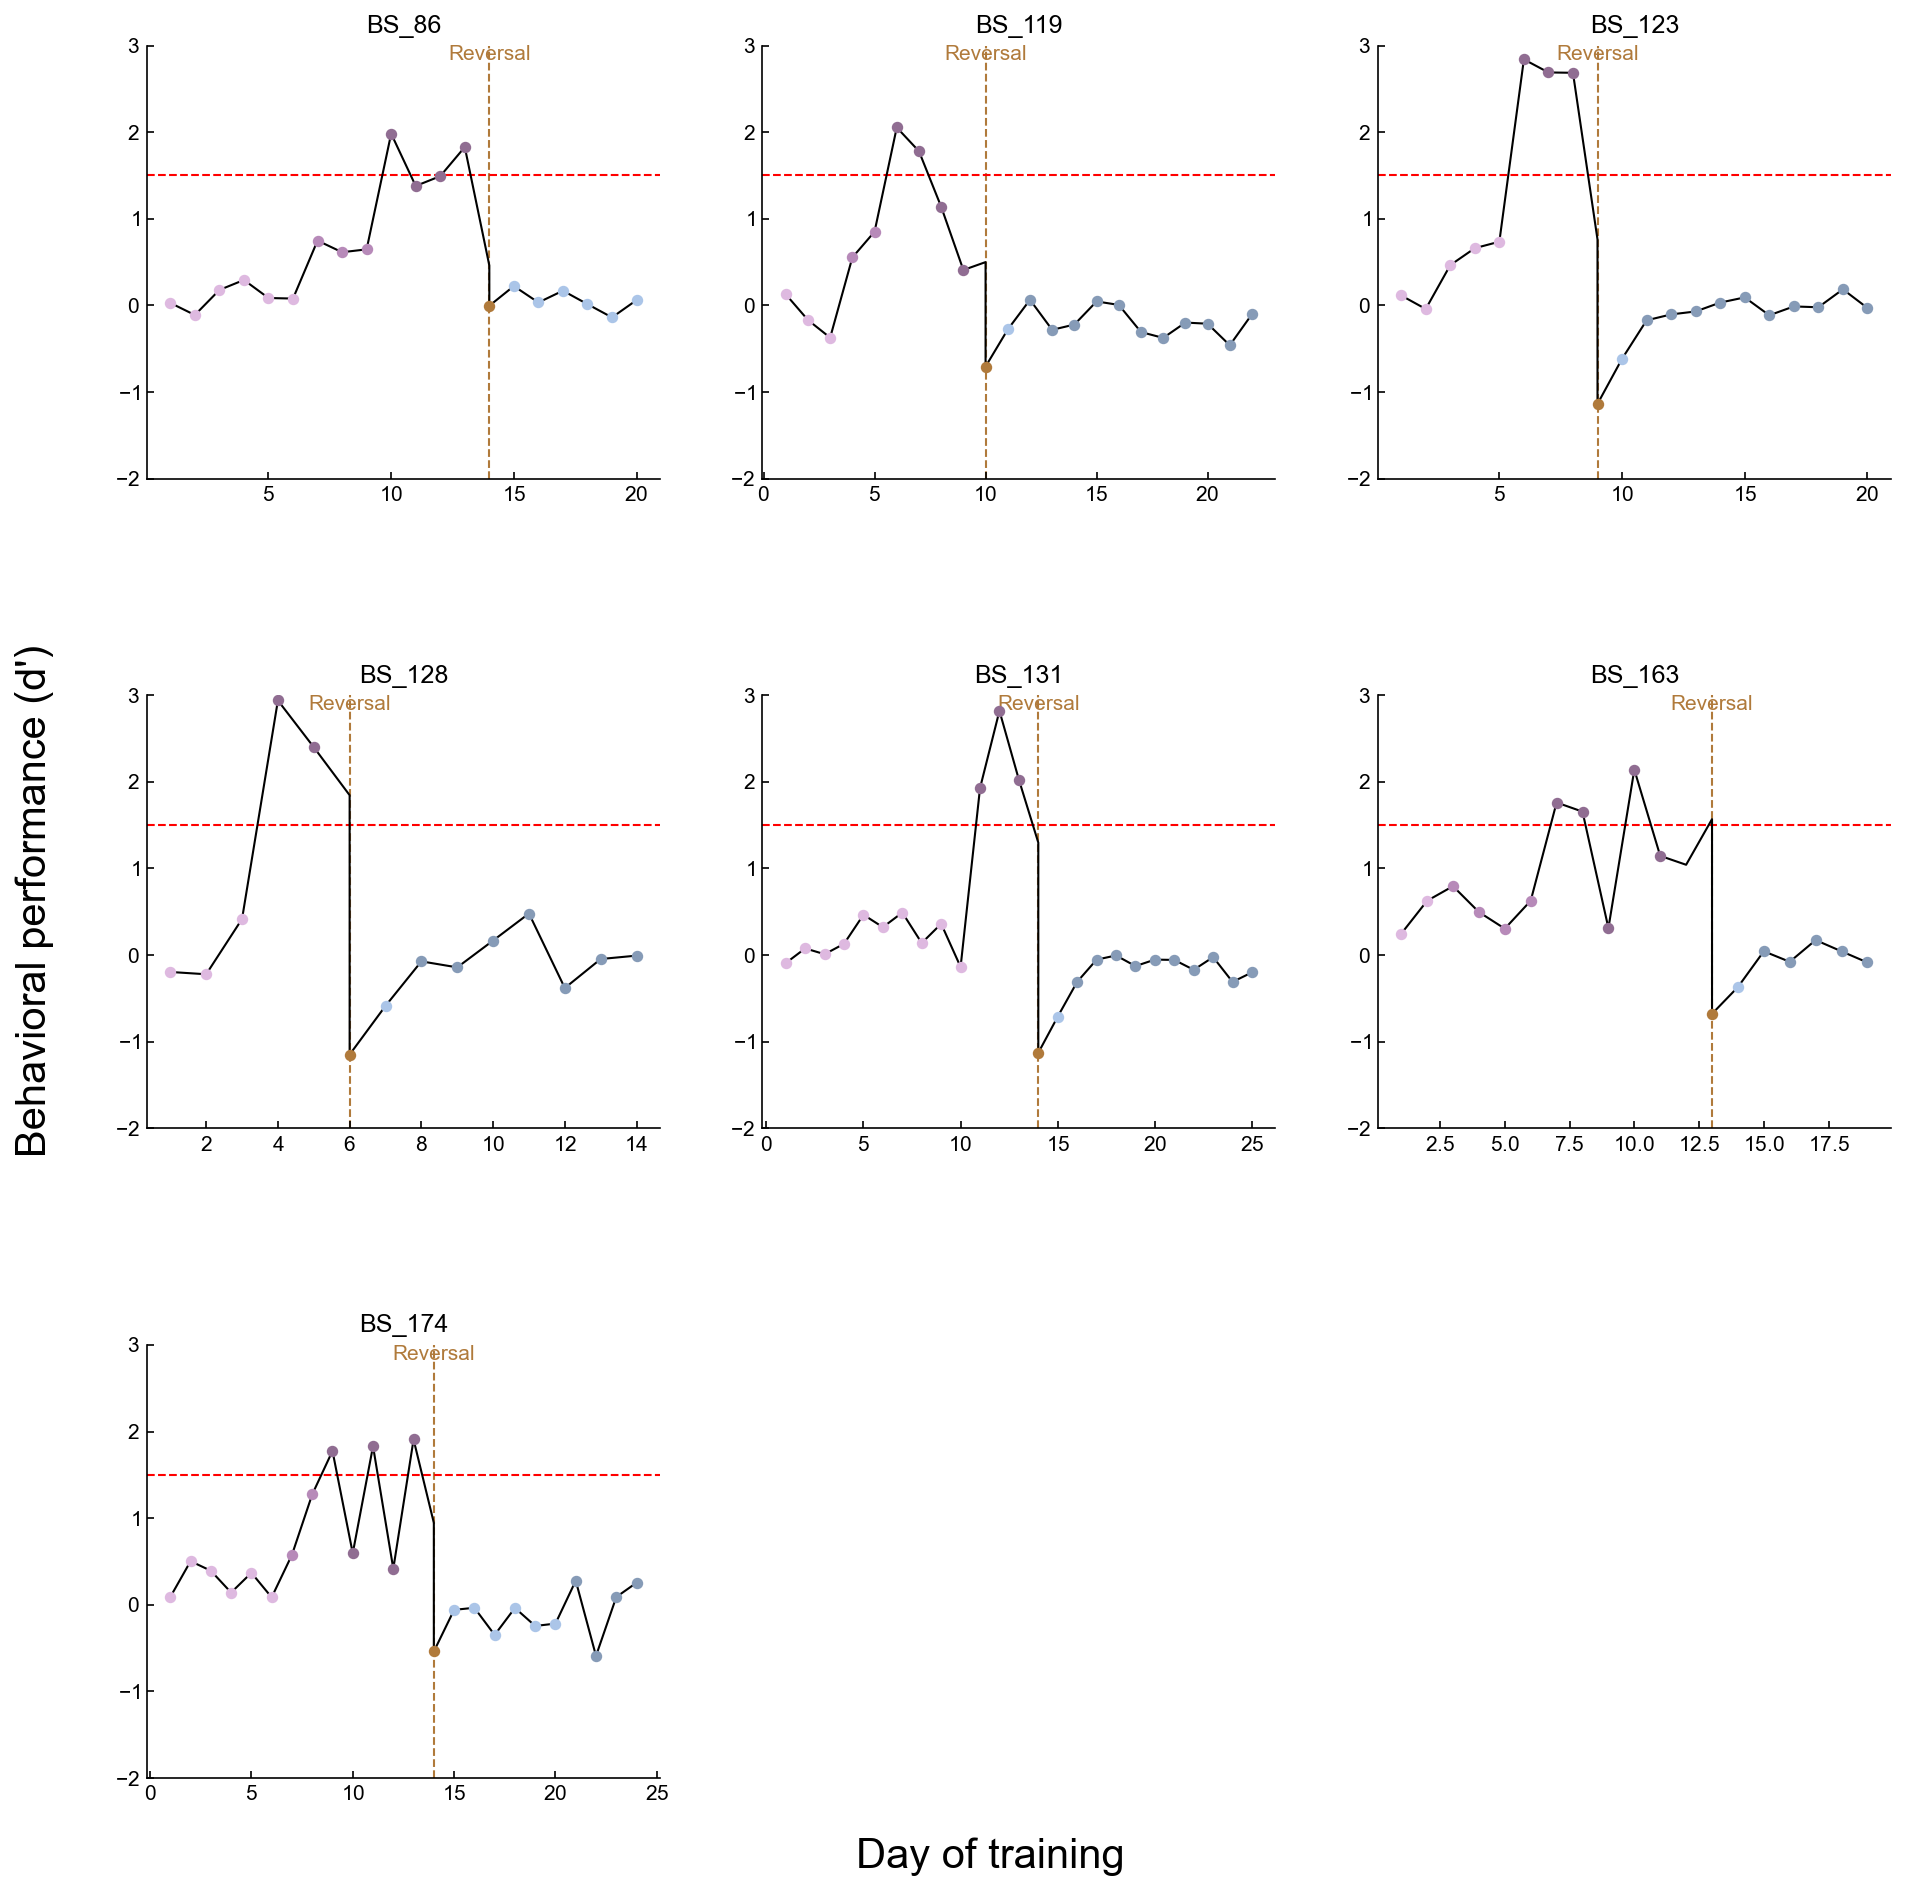

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


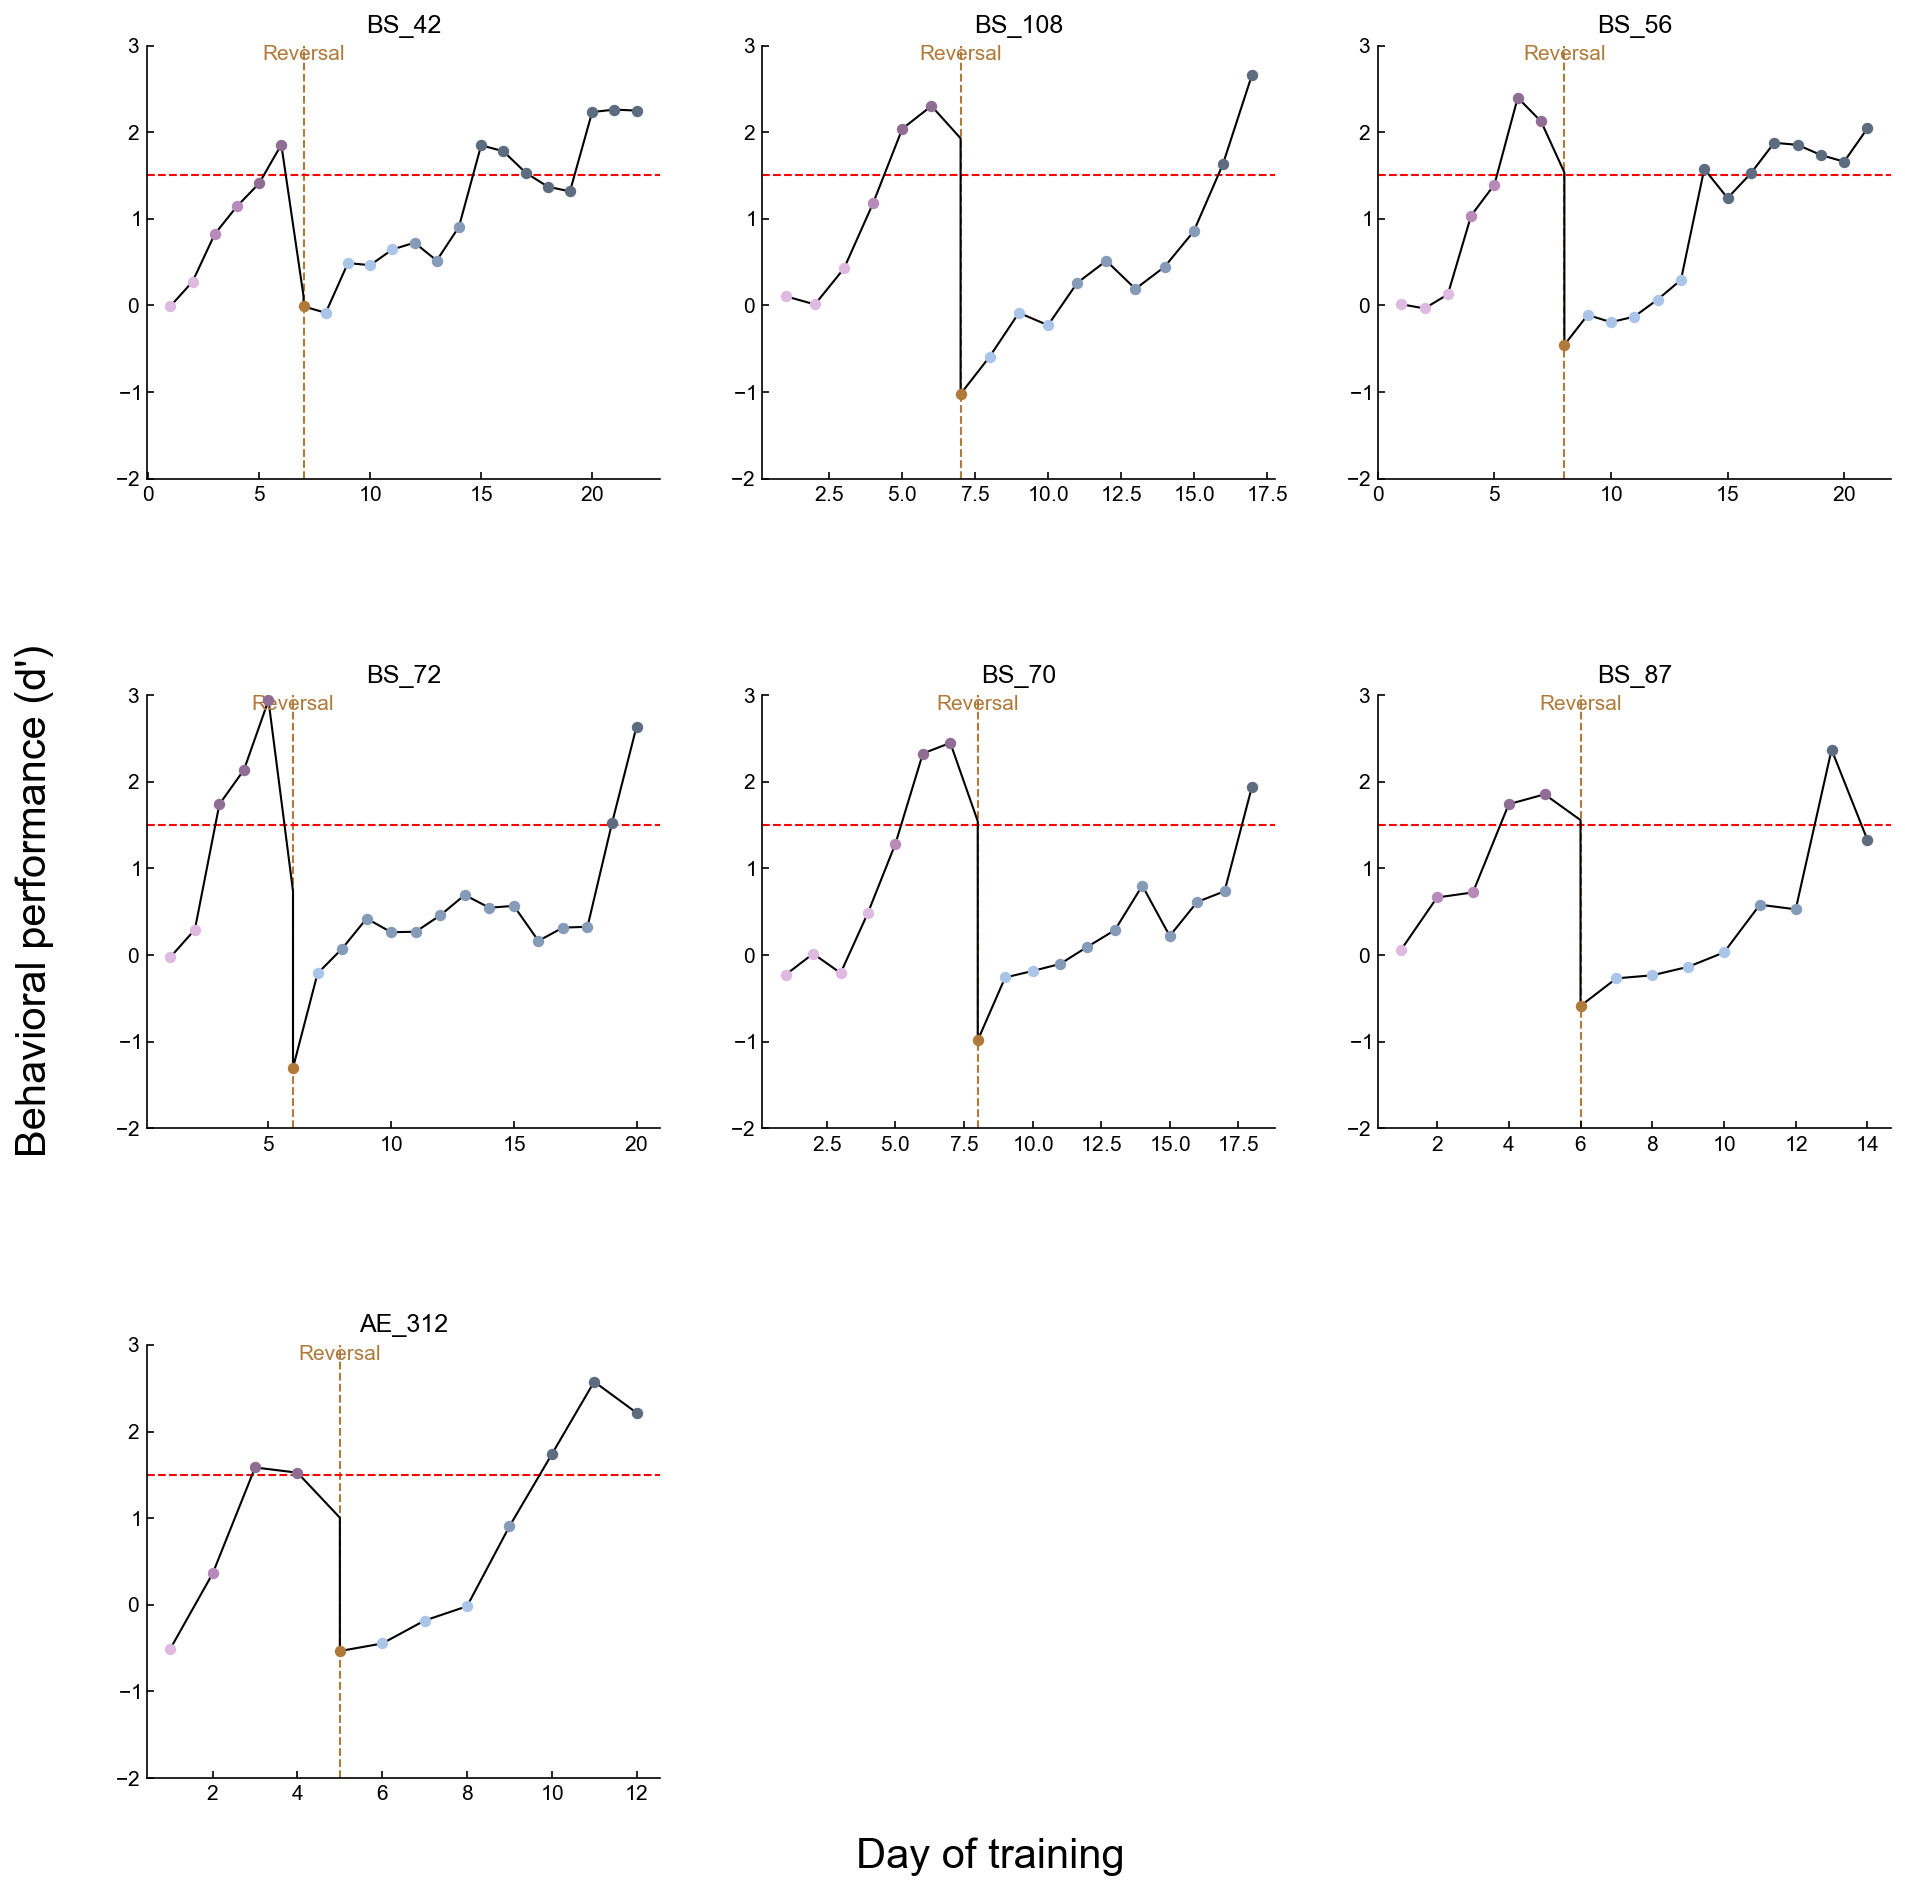

In [4]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True,noTrim=False)#(ephys_animals,animalBehaviors,plot=True,noTrim=False)
learning_phases2,_,_ = ilep.calculateLearningPhasesV2(did_not_learn_animals,animalBehaviors,plot=True,noTrim=False,noTrimPost=True)
# learning_phasesx,_,_ = ilep.calculateLearningPhasesV2(['BS_111'],animalBehaviors,plot=True,noTrim=False,noTrimPost=True)
learning_phases3,_,_ = ilep.calculateLearningPhasesV2(opsin_control_animals,animalBehaviors,plot=True,noTrim=False)
for d in learning_phases2:
    learning_phases[d] = learning_phases2[d]
for d in learning_phases3:
    learning_phases[d] = learning_phases3[d]

In [5]:
EnumSessionOps = []
EnumClustOps = []
sessions = os.listdir(ops_directory)
for session in tqdm(sessions):
    
    if session in ['BS_174_5_opto_AC.pickle']:     #This session excluded due to excessive gliosis (prevented recording the two days prior. Retired immediately after)
        continue
    
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    if sessionfile.meta.region != 'AC':
        continue
    if sessionfile.meta.task not in ['opto nonreversal','opto switch','opto reversal']:
        continue
        
    if sessionfile.meta.animal not in opsin_pre_animals:
        continue
        
    if hasattr(animalBehaviors[sessionfile.meta.animal],'cloudiness') and sessionfile.meta.day_of_training >= animalBehaviors[sessionfile.meta.animal].cloudiness:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSessionOps.append(session)
        EnumClustOps.append(clust)

100%|██████████| 211/211 [00:06<00:00, 33.98it/s]


In [6]:
EILphasesOps = np.full_like(EnumSessionOps,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSessionOps)):
    
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        day_after_reversal = day - animalBehaviors[animal].reversal
            
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphasesOps[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphasesOps[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphasesOps[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphasesOps[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day_after_reversal <= 2:
            EILphasesOps[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day_after_reversal <= 4:
            EILphasesOps[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day_after_reversal >= 5:
            EILphasesOps[idx] = 'post expert'
    except Exception as e:
        # print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
        raise e
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 895/895 [01:02<00:00, 14.29it/s]

errors for: []


In [9]:
EnumSessionControl = []
EnumClustControl = []
sessions1 = os.listdir(act_directory)
sessions2 = os.listdir(ops_directory)
sessions = np.concatenate((sessions1,sessions2))
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached([act_directory,ops_directory],session)
    
    if sessionfile.meta.region != 'AC':
        continue
    if sessionfile.meta.task not in ['nonreversal','switch','reversal','opto control nonreversal','opto control switch','opto control reversal']:
        continue
        
    if sessionfile.meta.animal not in control_pre_animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSessionControl.append(session)
        EnumClustControl.append(clust)

100%|██████████| 951/951 [00:18<00:00, 51.77it/s] 


In [10]:
EILphasesControl = np.full_like(EnumSessionControl,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSessionControl)):
    sessionfile = ilep.loadSessionCached([act_directory,ops_directory],session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch','opto control switch']:
            EILphasesControl[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','opto control nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphasesControl[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','opto control nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphasesControl[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','opto control nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphasesControl[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','opto control reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphasesControl[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','opto control reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphasesControl[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','opto control reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphasesControl[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        raise e
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 378/378 [00:18<00:00, 19.91it/s]

errors for: []


In [14]:
# FR_postearly_animal.append(FRmod_Ops_postearly_this_animal)
# FR_postlate_animal.append(FRmod_Ops_postlate_this_animal)
# FR_postexpert_animal.append(FRmod_Ops_postexpert_this_animal)

# #Remove nans
# FRmod_Ops_postearly_this_animal = ilep.rmnan(FRmod_Ops_postearly_this_animal)
# FRmod_Ops_postlate_this_animal = ilep.rmnan(FRmod_Ops_postlate_this_animal)
# FRmod_Ops_postexpert_this_animal = ilep.rmnan(FRmod_Ops_postexpert_this_animal)
# n_postearly_this_animal = len(FRmod_Ops_postearly_this_animal)
# n_postlate_this_animal = len(FRmod_Ops_postlate_this_animal)
# n_postexpert_this_animal = len(FRmod_Ops_postexpert_this_animal)

# percent_ncr_postearly_animal.append(np.mean(np.less(FRmod_Ops_postearly_this_animal,3.5)))
# percent_ncr_postlate_animal.append(np.mean(np.less(FRmod_Ops_postlate_this_animal,3.5)))
# percent_ncr_postexpert_animal.append(np.mean(np.less(FRmod_Ops_postexpert_this_animal,3.5)))
# n_postearly_animal.append(n_postearly_this_animal)
# n_postlate_animal.append(n_postlate_this_animal)
# n_postexpert_animal.append(n_postexpert_this_animal)

In [31]:
# preearly_Ops_animal = []
# prelate_Ops_animal = []
# preexpert_Ops_animal = []
# postearly_Ops_animal = []
# postlate_Ops_animal = []
# postexpert_Ops_animal = []

# pre_early_session = []

# percent_ncr_postearly_animal = []
# percent_ncr_postlate_animal = []
# percent_ncr_postexpert_animal = []
# n_postearly_animal = []
# n_postlate_animal = []
# n_postexpert_animal = []
# FR_postearly_animal = []
# FR_postlate_animal = []
# FR_postexpert_animal = []

animals_list = []
sessions_list = []
learning_phases_list = []
FRmod_list = []
condition_list = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSessionOps,EnumClustOps))):    
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    rev_day = 0#animalBehaviors[sessionfile.meta.animal].reversal                        #Just replacing this with 0 for now since all this code is designed around post-reversal
    day_relative_to_rev = sessionfile.meta.day_of_training - rev_day

    if sessionfile.meta.animal not in animals:
        continue
    if day_relative_to_rev < 1:
        continue
    if hasattr(animalBehaviors[sessionfile.meta.animal],'cloudiness') and sessionfile.meta.day_of_training >= animalBehaviors[sessionfile.meta.animal].cloudiness:
        continue

    try:
        FRmod = sessionfile.responsiveness[clust]['laser_on'].FRmodulation
    except Exception as e:
        print(f"{session} cluster {clust} has error: {e}")
        FRmod = np.nan

#     #1,2,3,4
#     #5,6
#     #7,8

    phase = 'N/A'
    #9,10,11,12
    if day_relative_to_rev in [1,2]:#[1,2,3,4]:
        phase = '1'
    if day_relative_to_rev in [3,4]:#[5,6,7]:
        phase = '2'
    if day_relative_to_rev >= 5:
        phase = '3'

    animals_list.append(sessionfile.meta.animal)
    sessions_list.append(session)
    learning_phases_list.append(phase)
    FRmod_list.append(FRmod)
    condition_list.append('opto')



for idx,(session,clust) in tqdm(enumerate(zip(EnumSessionControl,EnumClustControl))):
    sessionfile = ilep.loadSessionCached([act_directory,ops_directory],session)
    rev_day = 0#animalBehaviors[sessionfile.meta.animal].reversal
    day_relative_to_rev = sessionfile.meta.day_of_training - rev_day
    
    if sessionfile.meta.animal not in control_pre_animals:
        continue
    if day_relative_to_rev < 1:
        continue
    if EILphasesControl[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    try:
        FRmod = sessionfile.responsiveness[clust]['laser_on'].FRmodulation
    except Exception as e:
        print(f"{session} cluster {clust} has error: {e}")
        FRmod = np.nan

    #9,10,11,12
    phase = 'N/A'
    if EILphasesControl[idx] == 'pre early':
        phase = 'pre early'
    if EILphasesControl[idx] == 'pre late':
        phase = 'pre late'
    if EILphasesControl[idx] == 'pre expert':
        phase = 'pre expert'
        
    animals_list.append(sessionfile.meta.animal)
    sessions_list.append(session)
    learning_phases_list.append(phase)
    FRmod_list.append(FRmod)
    condition_list.append('control')

895it [01:03, 14.11it/s]
378it [00:19, 19.52it/s]


In [32]:
df_dict = dict()
df_dict['animal'] = animals_list
df_dict['session'] = sessions_list
df_dict['phase'] = learning_phases_list
df_dict['condition'] = condition_list
df_dict['FR modulation'] = FRmod_list
df = pd.DataFrame(df_dict)

In [33]:
df

,animal,session,phase,condition,FR modulation
0,AE_344,AE_344_10_opto_AC.pickle,3,opto,3.803419
1,AE_344,AE_344_10_opto_AC.pickle,3,opto,18.653846
2,AE_344,AE_344_10_opto_AC.pickle,3,opto,7.008547
3,AE_344,AE_344_10_opto_AC.pickle,3,opto,1.367521
4,AE_344,AE_344_10_opto_AC.pickle,3,opto,11.367521
...,...,...,...,...,...
1268,AE_359,AE_359_6_opto_control_AC.pickle,pre late,control,2.872928
1269,AE_359,AE_359_6_opto_control_AC.pickle,pre late,control,0.589319
1270,AE_359,AE_359_6_opto_control_AC.pickle,pre late,control,4.493554
1271,AE_359,AE_359_6_opto_control_AC.pickle,pre late,control,1.141805


In [44]:
np.unique(df['animal'])

array(['AE_344', 'AE_346', 'AE_350', 'AE_359', 'AE_367'], dtype=object)

In [48]:
# animal = animals[2]
df_opto = df#[df['animal']==animal]
df_opto = df_opto[df_opto['condition']=='opto']
opto_animals = np.unique(df_opto['animal'])

FR_postearly_animal = []
FR_postlate_animal = []
FR_postexpert_animal = []
for animal in opto_animals:
    
    postearly_animal = []
    postlate_animal = []
    postexpert_animal = []
    for row in df_opto.iloc():
        if row['animal'] != animal:
            continue
        if row['phase'] == '1':
            postearly_animal.append(row['FR modulation'])
        if row['phase'] == '2':
            postlate_animal.append(row['FR modulation'])
        if row['phase'] == '3':
            postexpert_animal.append(row['FR modulation'])
    postearly_animal = np.array(postearly_animal)
    postlate_animal = np.array(postlate_animal)
    postexpert_animal = np.array(postexpert_animal)
    
    FR_postearly_animal.append(postearly_animal)
    FR_postlate_animal.append(postlate_animal)
    FR_postexpert_animal.append(postexpert_animal)

    

df_control = df[df['condition']=='control']
control_animals = np.unique(df_control['animal'])

FR_Control_postearly_animal = []
FR_Control_postlate_animal = []
FR_Control_postexpert_animal = []
for animal in control_animals:
    
    postearly_animal = []
    postlate_animal = []
    postexpert_animal = []
    for row in df_control.iloc():
        if row['animal'] != animal:
            continue
        if row['phase'] == 'pre early':
            postearly_animal.append(row['FR modulation'])
        if row['phase'] == 'pre late':
            postlate_animal.append(row['FR modulation'])
        if row['phase'] == 'pre expert':
            postexpert_animal.append(row['FR modulation'])
    postearly_animal = np.array(postearly_animal)
    postlate_animal = np.array(postlate_animal)
    postexpert_animal = np.array(postexpert_animal)
    
    FR_Control_postearly_animal.append(postearly_animal)
    FR_Control_postlate_animal.append(postlate_animal)
    FR_Control_postexpert_animal.append(postexpert_animal)

In [49]:
df_control

,animal,session,phase,condition,FR modulation
895,AE_350,AE_350_10_opto_control_AC.pickle,pre expert,control,8.903509
896,AE_350,AE_350_10_opto_control_AC.pickle,pre expert,control,25.436508
897,AE_350,AE_350_10_opto_control_AC.pickle,pre expert,control,1.785714
898,AE_350,AE_350_10_opto_control_AC.pickle,pre expert,control,18.164251
899,AE_350,AE_350_10_opto_control_AC.pickle,pre expert,control,10.595238
...,...,...,...,...,...
1268,AE_359,AE_359_6_opto_control_AC.pickle,pre late,control,2.872928
1269,AE_359,AE_359_6_opto_control_AC.pickle,pre late,control,0.589319
1270,AE_359,AE_359_6_opto_control_AC.pickle,pre late,control,4.493554
1271,AE_359,AE_359_6_opto_control_AC.pickle,pre late,control,1.141805


In [50]:
np.unique(df_opto['animal'])

array(['AE_344', 'AE_346', 'AE_367'], dtype=object)

In [51]:
# mean_pc_NCR = np.array([np.nansum(np.array(d1)*np.array(d2))/np.nansum(d2) for d1,d2 in zip([percent_ncr_postearly_animal,percent_ncr_postlate_animal,percent_ncr_postexpert_animal],[n_postearly_animal,n_postlate_animal,n_postexpert_animal])])*100
# sem_pc_NCR = np.array([sem(ilep.rmnan(d)) for d in [percent_ncr_postearly_animal,percent_ncr_postlate_animal,percent_ncr_postexpert_animal]])*100

mean_pc_NCR = []
sem_pc_NCR = []
for FRmods in [FR_postearly_animal,FR_postlate_animal,FR_postexpert_animal]:
    Mw,SEMw = ilep.bootstrap_Mw_SEMw(FRmods,n_frac=1,CR_NCR_thresh=1.8)
    mean_pc_NCR.append(Mw)
    sem_pc_NCR.append(SEMw)

In [52]:
# mean_pc_NCR_control = np.array([np.nansum(np.array(d1)*np.array(d2))/np.nansum(d2) for d1,d2 in zip([percent_ncr_postearly_control_animal,percent_ncr_postlate_control_animal,percent_ncr_postexpert_control_animal],[n_postearly_control_animal,n_postlate_control_animal,n_postexpert_control_animal])])*100
# sem_pc_NCR_control = np.array([sem(ilep.rmnan(d)) for d in [percent_ncr_postearly_control_animal,percent_ncr_postlate_control_animal,percent_ncr_postexpert_control_animal]])*100

mean_pc_NCR_control = []
sem_pc_NCR_control = []
for FRmods in [FR_Control_postearly_animal,FR_Control_postlate_animal,FR_Control_postexpert_animal]:
    Mw,SEMw = ilep.bootstrap_Mw_SEMw(FRmods,n_frac=1,CR_NCR_thresh=3.5)
    mean_pc_NCR_control.append(Mw)
    sem_pc_NCR_control.append(SEMw)

In [53]:
print('loaded')

loaded


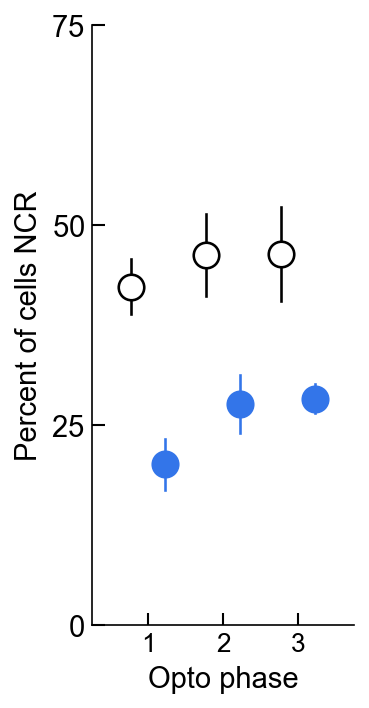

In [54]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')

fig,ax = make_axis_size(1.75, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0#0.1

################################################################################################################

wid = 0

offset=0.225
for idx,p in zip(range(6),[1,1,1]):
    
    ax.scatter([idx+wid+p*switch_offset-offset],(mean_pc_NCR_control[idx]),ec='k',fc='white',s=150,zorder=10,marker='o',lw=1.25)
    ax.plot([idx+wid+p*switch_offset-offset,idx+wid+p*switch_offset-offset],[(mean_pc_NCR_control[idx]-sem_pc_NCR_control[idx]),(mean_pc_NCR_control[idx]+sem_pc_NCR_control[idx])],color='k',lw=1.25,zorder=9)
    
    ax.scatter([idx+wid+p*switch_offset+offset],(mean_pc_NCR[idx]),c=LASER_COLOR,s=150,zorder=10,marker='o',lw=1.25)
    ax.plot([idx+wid+p*switch_offset+offset,idx+wid+p*switch_offset+offset],[(mean_pc_NCR[idx]-sem_pc_NCR[idx]),(mean_pc_NCR[idx]+sem_pc_NCR[idx])],color=LASER_COLOR,lw=1.25,zorder=9)
    
#ax.scatter([0,1,2,3,4,5],(mean_pc_NCR_passive)/100,fc='white',ec=GOOD_GREY,s=50,zorder=9,marker='o',lw=1)
# statsbar(ax,82,[1-wid-switch_offset,1+wid-switch_offset],stemheights=[passive_mean_pc_NCR[1]+passive_sem_pc_NCR[1] , mean_pc_NCR[1]+sem_pc_NCR[1]],text='*',lw=1)
# statsbar(ax,82,[4-wid+switch_offset,4+wid+switch_offset],stemheights=[passive_mean_pc_NCR[4]+passive_sem_pc_NCR[4] , mean_pc_NCR[4]+sem_pc_NCR[4]],text='****',lw=1)
# statsbar(ax,70,[5-wid+switch_offset,5+wid+switch_offset],stemheights=[passive_mean_pc_NCR[5]+passive_sem_pc_NCR[5] , mean_pc_NCR[5]+sem_pc_NCR[5]],text='****',lw=1)

################################################################################################################

labels = ['1','2','3']

ylab = ax.set_ylabel('Percent of cells NCR')
ax.set_ylim([0,75])
ax.set_yticks([0,25,50,75])
              
ax.set_xlim([-0.75-switch_offset,2.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset])
ax.set_xticklabels(labels)
ax.set_xlabel('Opto phase')

# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
# t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# ax.scatter([], [], ec=PASSIVE_COLOR,fc='white', s=50,lw=1,marker='o',label='passive')
# ax.scatter([], [], ec=PASSIVE_COLOR,fc=PASSIVE_COLOR, s=50,lw=1,marker='o',label='behaving')
# ax.legend(frameon=False,loc=(0.5,0.1),fontsize=14)

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
# Y = np.mean(ax.get_ylim())
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab]
fig.savefig(os.path.join(f'C:\\Users\\4thgr\\Downloads\\pre opto percent NCR {animal}.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')